Processing...
Done!
C:\Users\amssa\AppData\Local\Temp\ipykernel_18088\3253779128.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(sel

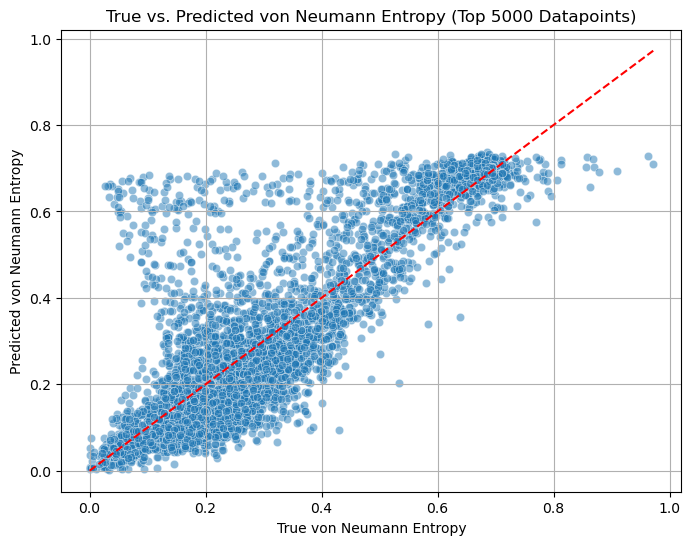

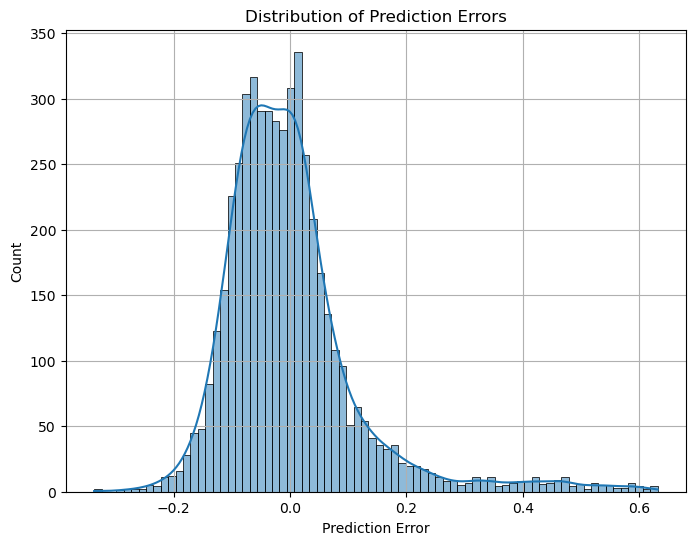

In [25]:
import os
import random
import logging
import joblib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data, DataLoader
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.nn import (
    GINEConv,
    Set2Set,
    GraphNorm
)
from torch_geometric.nn import NNConv, GlobalAttention, global_mean_pool, global_max_pool, GraphNorm

CONFIG = {
    'new_data_path': r'C:\Users\amssa\Documents\Codes\1-6\data1-6.parquet',  
    'processed_dir': './processed_new',
    'processed_file': 'data.pt',
    'scalers_path': 'scalers.pkl', 
    'batch_size': 256,
    'random_seed': 42,
    'distance_threshold': 25,  
    'model_path': 'best_gnn_model.pth', 
    'hidden_channels': 512,
    'dropout_p': 0.6,
    'edge_attr_dim': 2,  
    'num_datapoints': 5000,
    # For the NNConv-based model, 'heads' is not required. We ignore or remove it.
}

def setup_logging():
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        handlers=[logging.StreamHandler()]
    )

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

setup_logging()
set_seed(CONFIG['random_seed'])

class NewSpinSystemDataset(InMemoryDataset):
    def __init__(self, dataframe, root='.', transform=None, pre_transform=None):
        self.df = dataframe
        super(NewSpinSystemDataset, self).__init__(root, transform, pre_transform)
        if os.path.exists(self.processed_paths[0]):
            self.data, self.slices = torch.load(self.processed_paths[0])
        else:
            self.process()

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return [CONFIG['processed_file']]

    def download(self):
        pass

    def process(self):
        data_list = []
        for idx, row in self.df.iterrows():
            Nx = int(row['Nx'])
            Ny = 2
            N = Nx * Ny

            x_spacing = row['x_spacing']
            y_spacing = row['y_spacing']
            positions = np.array([
                (col * x_spacing, row_idx * y_spacing)
                for row_idx in range(Nx) for col in range(Ny)
            ], dtype=np.float32)
            positions = torch.tensor(positions, dtype=torch.float32)

            # Normalize positions
            pos_min = positions.min(dim=0).values
            pos_max = positions.max(dim=0).values
            normalized_positions = (positions - pos_min) / (pos_max - pos_min + 1e-8)

            state_indices = row['Top_50_Indices']
            state_probs = row['Top_50_Probabilities']

            p_rydberg = [0.0] * N
            for state, prob in zip(state_indices, state_probs):
                state = int(state)
                for i in range(N):
                    if state & (1 << i):
                        p_rydberg[i] += prob
            p_rydberg = torch.tensor(p_rydberg, dtype=torch.float32).unsqueeze(1)

            # N_A feature
            N_A_idx = int(row['N_A'])
            N_A_feature = torch.zeros((N, 1), dtype=torch.float32)
            if 0 <= N_A_idx < N:
                N_A_feature[N_A_idx] = 1.0

            node_features = torch.cat([normalized_positions, p_rydberg, N_A_feature], dim=1)  # [N,4]

            # Edge construction
            distance_threshold = CONFIG['distance_threshold']
            nbrs = NearestNeighbors(radius=distance_threshold, algorithm='ball_tree').fit(positions.numpy())
            indices = nbrs.radius_neighbors(positions.numpy(), return_distance=False)

            edge_index = []
            for i_node in range(N):
                for j_node in indices[i_node]:
                    if i_node < j_node:
                        edge_index.append([i_node, j_node])
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

            if edge_index.size(1) > 0:
                pos_i = positions[edge_index[0]]
                pos_j = positions[edge_index[1]]
                distances = torch.norm(pos_i - pos_j, dim=1, keepdim=True)
                epsilon = 1e-8
                inv_r6 = 1.0 / (distances.pow(6) + epsilon)
            else:
                inv_r6 = torch.empty((0, 1), dtype=torch.float32)

            # Compute edge correlations
            edge_tuples = [(edge_index[0, k].item(), edge_index[1, k].item()) for k in range(edge_index.size(1))]
            edge_joint_probs = {edge: 0.0 for edge in edge_tuples}

            for state, prob in zip(state_indices, state_probs):
                state = int(state)
                rydberg_particles = [i_part for i_part in range(N) if state & (1 << i_part)]
                for i_part in rydberg_particles:
                    for j_part in rydberg_particles:
                        if i_part < j_part and (i_part, j_part) in edge_joint_probs:
                            edge_joint_probs[(i_part, j_part)] += prob

            edge_correlation = []
            for k in range(edge_index.size(1)):
                i_part = edge_index[0, k].item()
                j_part = edge_index[1, k].item()
                joint_prob = edge_joint_probs.get((i_part, j_part), 0.0)
                p_ryd_i = p_rydberg[i_part].item()
                p_ryd_j = p_rydberg[j_part].item()
                correlation = joint_prob - p_ryd_i * p_ryd_j
                edge_correlation.append([correlation])
            edge_correlation = torch.tensor(edge_correlation, dtype=torch.float32)

            if edge_index.size(1) > 0:
                edge_attr = torch.cat([inv_r6, edge_correlation], dim=1)
            else:
                edge_attr = torch.empty((0, 2), dtype=torch.float32)

            # Target: Von Neumann Entropy
            # Convert to entropy_per_Nx: original_entropy / Nx
            original_entropy = row['Von_Neumann_Entropy']
            #entropy_per_Nx = original_entropy / Nx
            log_entropy_per_Nx = np.log(original_entropy+ 1e-9)
            entropy = torch.tensor([log_entropy_per_Nx], dtype=torch.float32)

            data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=entropy)
            #data.Nx = Nx

            # Additional features (Omega, Delta, Energy)
            data.Omega = torch.tensor([[row['Omega']]], dtype=torch.float32)
            data.Delta = torch.tensor([[row['Delta']]], dtype=torch.float32)
            data.Energy = torch.tensor([[row['Energy']]], dtype=torch.float32)

            data_list.append(data)

        data, slices = self.collate(data_list)
        os.makedirs(self.root, exist_ok=True)
        torch.save((data, slices), self.processed_paths[0])

class ImprovedGNNModel(nn.Module):
    def __init__(self, num_node_features, edge_attr_dim, hidden_channels, dropout_p=0.5):
        super(ImprovedGNNModel, self).__init__()

        # MLP for GINEConv
        def mlp(in_channels, out_channels):
            return nn.Sequential(
                nn.Linear(in_channels, hidden_channels),
                nn.ReLU(),
                nn.Linear(hidden_channels, out_channels)
            )

        # GINEConv layers with edge_dim specified
        self.conv1 = GINEConv(mlp(num_node_features, hidden_channels), edge_dim=edge_attr_dim)
        self.norm1 = GraphNorm(hidden_channels)

        self.conv2 = GINEConv(mlp(hidden_channels, hidden_channels), edge_dim=edge_attr_dim)
        self.norm2 = GraphNorm(hidden_channels)

        self.conv3 = GINEConv(mlp(hidden_channels, hidden_channels), edge_dim=edge_attr_dim)
        self.norm3 = GraphNorm(hidden_channels)

        self.dropout = nn.Dropout(p=dropout_p)

        # Set2Set for global readout
        self.readout = Set2Set(hidden_channels, processing_steps=3, num_layers=2)

        # Fully connected MLP after readout
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_channels, 2 * hidden_channels),
            GraphNorm(2 * hidden_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),

            nn.Linear(2 * hidden_channels, hidden_channels),
            GraphNorm(hidden_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),

            nn.Linear(hidden_channels, 1)
        )

    def forward(self, x, edge_index, edge_attr, batch):
        # Layer 1
        h = self.conv1(x, edge_index, edge_attr)
        h = self.norm1(h, batch)
        h = F.relu(h)
        h1 = h

        # Layer 2
        h = self.conv2(h, edge_index, edge_attr)
        h = self.norm2(h, batch)
        h = F.relu(h)
        h = h + h1  # Residual
        h2 = h

        # Layer 3
        h = self.conv3(h, edge_index, edge_attr)
        h = self.norm3(h, batch)
        h = F.relu(h)
        h = h + h2  # Residual

        h = self.dropout(h)

        # Global readout
        h = self.readout(h, batch)

        # Fully connected MLP
        out = self.fc(h)
        return out.squeeze()

def main():
    if not os.path.exists(CONFIG['new_data_path']):
        logging.error(f"New test data file not found at {CONFIG['new_data_path']}")
        return
    df = pd.read_parquet(CONFIG['new_data_path'])

    N = CONFIG['num_datapoints']
    df = df.head(N)
    df = df.sample(frac=1, random_state=CONFIG['random_seed']).reset_index(drop=True)

    dataset = NewSpinSystemDataset(df, root=CONFIG['processed_dir'])
    logging.info(f"New test dataset loaded with {len(dataset)} graphs (first {N} datapoints).")

    scalers = joblib.load(CONFIG['scalers_path'])
    logging.info("Scalers loaded.")

    features = ['Omega', 'Delta', 'Energy']
    def normalize(dataset, scalers):
        for data in dataset:
            for feature in features:
                scaled = scalers[feature].transform(getattr(data, feature).numpy())
                setattr(data, feature, torch.tensor(scaled, dtype=torch.float))
        return dataset

    dataset = normalize(dataset, scalers)

    test_loader = DataLoader(dataset, batch_size=CONFIG['batch_size'], shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logging.info(f'Using device: {device}')

    num_node_features = dataset[0].num_node_features
    edge_attr_dim = dataset[0].edge_attr.shape[1]
    model = ImprovedGNNModel(
        num_node_features=num_node_features,
        edge_attr_dim=edge_attr_dim,
        hidden_channels=CONFIG['hidden_channels'],
        dropout_p=CONFIG['dropout_p']
    ).to(device)

    model.load_state_dict(torch.load(CONFIG['model_path'], map_location=device))
    model.eval()
    logging.info("Model loaded and set to eval mode.")

    y_true_list = []
    y_pred_list = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            log_pred = model(data.x, data.edge_index, data.edge_attr, data.batch)

            # Convert back to original entropy scale
            #Nx = data.Nx
            y_pred = torch.exp(log_pred) 
            y_true = torch.exp(data.y.squeeze()) 

            y_true_list.append(y_true.cpu().numpy())
            y_pred_list.append(y_pred.cpu().numpy())

    y_true_all = np.concatenate(y_true_list)
    y_pred_all = np.concatenate(y_pred_list)

    mse = mean_squared_error(y_true_all, y_pred_all)
    mae = mean_absolute_error(y_true_all, y_pred_all)
    r2 = r2_score(y_true_all, y_pred_all)
    nonzero_mask = (y_true_all != 0)
    if nonzero_mask.sum() > 0:
        mape = (np.abs((y_true_all[nonzero_mask] - y_pred_all[nonzero_mask]) / y_true_all[nonzero_mask]) * 100).mean()
    else:
        mape = float('nan')

    logging.info(f'Test MSE: {mse:.6f}')
    logging.info(f'Test MAE: {mae:.6f}')
    logging.info(f'Test R2: {r2:.6f}')
    logging.info(f'Test MAPE: {mape:.2f}%')

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true_all, y=y_pred_all, alpha=0.5)
    min_val = min(y_true_all.min(), y_pred_all.min())
    max_val = max(y_true_all.max(), y_pred_all.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel('True von Neumann Entropy')
    plt.ylabel('Predicted von Neumann Entropy')
    plt.title(f'True vs. Predicted von Neumann Entropy (Top {N} Datapoints)')
    plt.grid(True)
    plt.show()

    errors = y_pred_all - y_true_all
    plt.figure(figsize=(8, 6))
    sns.histplot(errors, kde=True)
    plt.xlabel('Prediction Error')
    plt.title('Distribution of Prediction Errors')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


2024-12-08 22:20:38,089 [INFO] First few rows of the new dataset:
2024-12-08 22:20:38,090 [INFO]    Nx      Delta      Omega  x_spacing  y_spacing      Energy  \
0   8   9.462071  42.925426   6.436142   6.390225 -257.749858   
1   8  12.000790  35.222592   7.612714   6.531852 -239.430200   
2   8  32.000535  11.928594   4.555005   6.307988 -156.523507   
3   8  34.593822  47.406627   5.262694   7.505088 -404.694672   
4   8   3.378173   6.381088   6.736093   6.058615  -33.839285   

                                      Top_50_Indices  \
0  [0, 16384, 2, 1, 32768, 1024, 32, 2048, 16, 51...   
1  [0, 2, 16384, 1, 32768, 16386, 32769, 32770, 1...   
2  [35089, 34961, 17954, 17506, 34833, 17442, 350...   
3  [26214, 39321, 26210, 18022, 35225, 39313, 261...   
4  [0, 32768, 1, 2, 16384, 32769, 16386, 32770, 1...   

                                Top_50_Probabilities  Von_Neumann_Entropy  N_A  
0  [0.003997673163174206, 0.0028145491157288887, ...             0.141149   11  
1  [0.0011994

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Nx                    500 non-null    int64  
 1   Delta                 500 non-null    float64
 2   Omega                 500 non-null    float64
 3   x_spacing             500 non-null    float64
 4   y_spacing             500 non-null    float64
 5   Energy                500 non-null    float64
 6   Top_50_Indices        500 non-null    object 
 7   Top_50_Probabilities  500 non-null    object 
 8   Von_Neumann_Entropy   500 non-null    float64
 9   N_A                   500 non-null    int64  
dtypes: float64(6), int64(2), object(2)
memory usage: 39.2+ KB


Done!
C:\Users\amssa\AppData\Local\Temp\ipykernel_18088\1711141517.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_pa

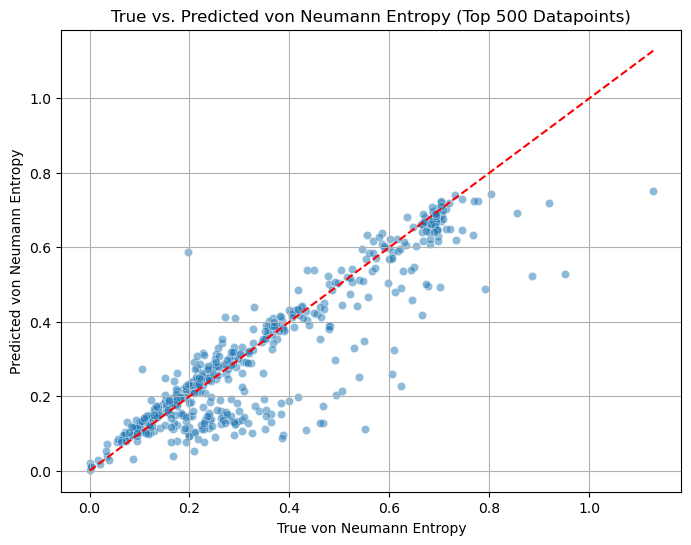

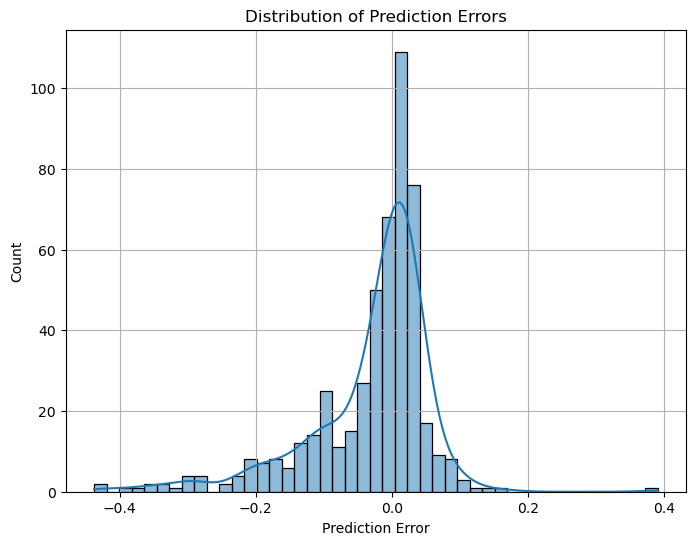

In [66]:
import os
import random
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data, DataLoader
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.nn import (
    GINEConv,
    Set2Set,
    GraphNorm
)

CONFIG = {
    'new_data_path': r'C:\Users\amssa\Documents\Codes\1-6\testing1-10.parquet',
    'processed_dir': './processed_test',
    'processed_file': 'data.pt',
    'batch_size': 256,
    'random_seed': 42,
    'distance_threshold': 25,
    'model_path': 'best_gnn_model_improved.pth',
    'hidden_channels': 1024,
    'dropout_p': 0.6,
    'num_datapoints': 500,
}

def setup_logging():
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        handlers=[logging.StreamHandler()]
    )

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

setup_logging()
set_seed(CONFIG['random_seed'])

class NewSpinSystemDataset(InMemoryDataset):
    def __init__(self, dataframe, root='.', transform=None, pre_transform=None):
        self.df = dataframe
        super(NewSpinSystemDataset, self).__init__(root, transform, pre_transform)
        if os.path.exists(self.processed_paths[0]):
            self.data, self.slices = torch.load(self.processed_paths[0])
        else:
            self.process()

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return [CONFIG['processed_file']]

    def download(self):
        pass

    def process(self):
        data_list = []
        for idx, row in self.df.iterrows():
            Nx = int(row['Nx'])
            Ny = 2
            N = Nx * Ny

            x_spacing = row['x_spacing']
            y_spacing = row['y_spacing']
            positions = np.array([
                (col * x_spacing, row_idx * y_spacing)
                for row_idx in range(Nx) for col in range(Ny)
            ], dtype=np.float32)
            positions = torch.tensor(positions, dtype=torch.float32)

            # Normalize positions
            pos_min = positions.min(dim=0).values
            pos_max = positions.max(dim=0).values
            normalized_positions = (positions - pos_min) / (pos_max - pos_min + 1e-8)

            state_indices = row['Top_50_Indices']
            state_probs = row['Top_50_Probabilities']

            p_rydberg = [0.0] * N
            for state, prob in zip(state_indices, state_probs):
                state = int(state)
                for i in range(N):
                    if state & (1 << i):
                        p_rydberg[i] += prob
            p_rydberg = torch.tensor(p_rydberg, dtype=torch.float32).unsqueeze(1)

            # N_A feature
            try:
                N_A_idx = int(row['N_A'])
            except ValueError:
                logging.error(f"Graph {idx}: N_A value '{row['N_A']}' is not an integer.")
                raise

            N_A_feature = torch.zeros((N, 1), dtype=torch.float32)
            if 0 <= N_A_idx < N:
                N_A_feature[N_A_idx] = 1.0
            else:
                logging.warning(f'Graph {idx}: N_A index {N_A_idx} out of range for {N} nodes.')

            # Node features: normalized_positions(2) + p_rydberg(1) + N_A(1) = 4 features
            node_features = torch.cat([normalized_positions, p_rydberg, N_A_feature], dim=1)

            distance_threshold = CONFIG['distance_threshold']
            nbrs = NearestNeighbors(radius=distance_threshold, algorithm='ball_tree').fit(positions.numpy())
            indices = nbrs.radius_neighbors(positions.numpy(), return_distance=False)

            edge_index = []
            for i_node in range(N):
                for j_node in indices[i_node]:
                    if i_node < j_node:
                        edge_index.append([i_node, j_node])
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

            if edge_index.size(1) > 0:
                pos_i = positions[edge_index[0]]
                pos_j = positions[edge_index[1]]
                distances = torch.norm(pos_i - pos_j, dim=1, keepdim=True)
                epsilon = 1e-8
                inv_r6 = 1.0 / (distances.pow(6) + epsilon)
            else:
                distances = torch.empty((0, 1), dtype=torch.float32)
                inv_r6 = torch.empty((0, 1), dtype=torch.float32)

            # Compute edge correlations
            edge_tuples = [(edge_index[0, k].item(), edge_index[1, k].item()) for k in range(edge_index.size(1))]
            edge_joint_probs = {edge: 0.0 for edge in edge_tuples}

            for state, prob in zip(state_indices, state_probs):
                state = int(state)
                rydberg_particles = [i_part for i_part in range(N) if state & (1 << i_part)]
                for i_part in rydberg_particles:
                    for j_part in rydberg_particles:
                        if i_part < j_part and (i_part, j_part) in edge_joint_probs:
                            edge_joint_probs[(i_part, j_part)] += prob

            edge_correlation = []
            for k in range(edge_index.size(1)):
                i_part = edge_index[0, k].item()
                j_part = edge_index[1, k].item()
                joint_prob = edge_joint_probs.get((i_part, j_part), 0.0)
                p_ryd_i = p_rydberg[i_part].item()
                p_ryd_j = p_rydberg[j_part].item()
                correlation = joint_prob - p_ryd_i * p_ryd_j
                edge_correlation.append([correlation])
            edge_correlation = torch.tensor(edge_correlation, dtype=torch.float32)

            if edge_index.size(1) > 0:
                edge_attr = torch.cat([inv_r6, edge_correlation], dim=1)
            else:
                edge_attr = torch.empty((0, 2), dtype=torch.float32)

            # Target: Von Neumann Entropy
            original_entropy = row['Von_Neumann_Entropy']
            log_entropy = np.log(original_entropy + 1e-9)
            entropy = torch.tensor([log_entropy], dtype=torch.float32)

            # Derived global features (same as training)
            p_ryd_mean = p_rydberg.mean().item()
            p_ryd_std = p_rydberg.std().item() if p_rydberg.numel() > 1 else 0.0

            if edge_correlation.numel() > 1:
                edge_corr_mean = edge_correlation.mean().item()
                edge_corr_std = edge_correlation.std().item()
            elif edge_correlation.numel() == 1:
                edge_corr_mean = edge_correlation.mean().item()
                edge_corr_std = 0.0
            else:
                edge_corr_mean = 0.0
                edge_corr_std = 0.0

            if edge_index.size(1) > 0:
                degrees = torch.bincount(torch.cat([edge_index[0], edge_index[1]]), minlength=N)
                avg_degree = degrees.float().mean().item()
            else:
                avg_degree = 0.0

            if distances.numel() > 1:
                pos_dist_mean = distances.mean().item()
                pos_dist_std = distances.std().item()
            elif distances.numel() == 1:
                pos_dist_mean = distances.mean().item()
                pos_dist_std = 0.0
            else:
                pos_dist_mean = 0.0
                pos_dist_std = 0.0

            global_features = torch.tensor([
                Nx, Ny,
                p_ryd_mean, p_ryd_std,
                edge_corr_mean, edge_corr_std,
                avg_degree,
                pos_dist_mean, pos_dist_std
            ], dtype=torch.float32).unsqueeze(0)

            data = Data(
                x=node_features,
                edge_index=edge_index,
                edge_attr=edge_attr,
                y=entropy
            )
            data.global_features = global_features

            data_list.append(data)

        data, slices = self.collate(data_list)
        os.makedirs(self.root, exist_ok=True)
        torch.save((data, slices), self.processed_paths[0])

class ImprovedGNNModel(nn.Module):
    def __init__(self, num_node_features, edge_attr_dim, hidden_channels, dropout_p=0.5, global_feature_dim=9):
        super(ImprovedGNNModel, self).__init__()
        def mlp(in_channels, out_channels):
            return nn.Sequential(
                nn.Linear(in_channels, hidden_channels),
                nn.ReLU(),
                nn.Linear(hidden_channels, out_channels)
            )

        self.conv1 = GINEConv(mlp(num_node_features, hidden_channels), edge_dim=edge_attr_dim)
        self.norm1 = GraphNorm(hidden_channels)
        self.conv2 = GINEConv(mlp(hidden_channels, hidden_channels), edge_dim=edge_attr_dim)
        self.norm2 = GraphNorm(hidden_channels)
        self.conv3 = GINEConv(mlp(hidden_channels, hidden_channels), edge_dim=edge_attr_dim)
        self.norm3 = GraphNorm(hidden_channels)

        self.dropout = nn.Dropout(p=dropout_p)
        self.readout = Set2Set(hidden_channels, processing_steps=3, num_layers=2)

        input_dim = 2 * hidden_channels + global_feature_dim
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 2 * hidden_channels),
            GraphNorm(2 * hidden_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),

            nn.Linear(2 * hidden_channels, hidden_channels),
            GraphNorm(hidden_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),

            nn.Linear(hidden_channels, 1)
        )

    def forward(self, x, edge_index, edge_attr, batch, global_features):
        h = self.conv1(x, edge_index, edge_attr)
        h = self.norm1(h, batch)
        h = F.relu(h)
        h1 = h

        h = self.conv2(h, edge_index, edge_attr)
        h = self.norm2(h, batch)
        h = F.relu(h)
        h = h + h1
        h2 = h

        h = self.conv3(h, edge_index, edge_attr)
        h = self.norm3(h, batch)
        h = F.relu(h)
        h = h + h2

        h = self.dropout(h)
        h = self.readout(h, batch)
        h = torch.cat([h, global_features], dim=-1)
        out = self.fc(h)
        return out.squeeze()

def load_and_filter_data(config):
    if not os.path.exists(config['new_data_path']):
        logging.error(f"New test data file not found at {config['new_data_path']}")
        raise FileNotFoundError(f"Data file not found at {config['new_data_path']}")

    df = pd.read_parquet(config['new_data_path'])

    logging.info("First few rows of the new dataset:")
    logging.info(df.head())
    logging.info("\nNew Dataset Information:")
    logging.info(df.info())

    N = config['num_datapoints']
    df = df.head(N)
    df = df.sample(frac=1, random_state=config['random_seed']).reset_index(drop=True)

    # Removed N_A == Nx filtering
    return df

def main():
    df_filtered = load_and_filter_data(CONFIG)
    dataset = NewSpinSystemDataset(df_filtered, root=CONFIG['processed_dir'])
    logging.info(f"New test dataset loaded with {len(dataset)} graphs.")

    test_loader = DataLoader(dataset, batch_size=CONFIG['batch_size'], shuffle=False)
    logging.info(f"Test DataLoader created with batch size {CONFIG['batch_size']}.")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logging.info(f'Using device: {device}')

    if len(dataset) == 0:
        logging.error("No data available in the dataset. Exiting.")
        return

    sample_data = dataset[0]
    num_node_features = sample_data.num_node_features
    edge_attr_dim = sample_data.edge_attr.shape[1] if sample_data.edge_attr.numel() > 0 else 0
    global_feature_dim = sample_data.global_features.shape[1]

    model = ImprovedGNNModel(
        num_node_features=num_node_features,
        edge_attr_dim=edge_attr_dim,
        hidden_channels=CONFIG['hidden_channels'],
        dropout_p=CONFIG['dropout_p'],
        global_feature_dim=global_feature_dim
    ).to(device)

    if not os.path.exists(CONFIG['model_path']):
        logging.error(f"Model file not found at {CONFIG['model_path']}. Ensure the model is trained and saved.")
        return

    model.load_state_dict(torch.load(CONFIG['model_path'], map_location=device))
    model.eval()
    logging.info("Model loaded and set to eval mode.")

    y_true_list = []
    y_pred_list = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            log_pred = model(data.x, data.edge_index, data.edge_attr, data.batch, data.global_features)

            # Convert from log scale to original scale
            y_pred = torch.exp(log_pred)
            y_true = torch.exp(data.y.squeeze())

            y_true_list.append(y_true.cpu().numpy())
            y_pred_list.append(y_pred.cpu().numpy())

    y_true_all = np.concatenate(y_true_list)
    y_pred_all = np.concatenate(y_pred_list)

    mse = mean_squared_error(y_true_all, y_pred_all)
    mae = mean_absolute_error(y_true_all, y_pred_all)
    r2 = r2_score(y_true_all, y_pred_all)
    nonzero_mask = (y_true_all != 0)
    mape = (np.abs((y_true_all[nonzero_mask] - y_pred_all[nonzero_mask]) / y_true_all[nonzero_mask]) * 100).mean() if nonzero_mask.sum() > 0 else float('nan')

    logging.info(f'Test MSE: {mse:.6f}')
    logging.info(f'Test MAE: {mae:.6f}')
    logging.info(f'Test R2: {r2:.6f}')
    logging.info(f'Test MAPE: {mape:.2f}%')

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true_all, y=y_pred_all, alpha=0.5)
    min_val = min(y_true_all.min(), y_pred_all.min())
    max_val = max(y_true_all.max(), y_pred_all.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel('True von Neumann Entropy')
    plt.ylabel('Predicted von Neumann Entropy')
    plt.title(f'True vs. Predicted von Neumann Entropy (Top {CONFIG["num_datapoints"]} Datapoints)')
    plt.grid(True)
    plt.show()

    errors = y_pred_all - y_true_all
    plt.figure(figsize=(8, 6))
    sns.histplot(errors, kde=True)
    plt.xlabel('Prediction Error')
    plt.title('Distribution of Prediction Errors')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
